## Query

In [1]:
import pandas as pd
import numpy as np
import os as os
import pickle
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.util import ngrams
import acessos as ac
from arabica import arabica_freq
from unidecode import unidecode
import re
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import plotly.express as px
import texthero as hero
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [2]:
query = """

select 
msg.id_issue
, msg.dt_envio_mensagem
, nm_entidade
, msg.ds_message
, novas_tags.hierarquia_4
, novas_tags.fila_de_atendimento
from cx_curated_zone.helpshift_issues_messages msg
left join "cx_curated_zone"."helpshift_issues" AS issues_macro ON msg."id_issue" = issues_macro."id_issue"
left join "cx_curated_zone"."helpshift_tag_niveis" AS helpshift_tag ON msg."id_issue" = helpshift_tag."id_issue"
left join processed_zone_api_cxm_tags.tags_hierarquia_gerencial as novas_tags ON trim(lower(n3)) = trim(lower(nm_tag_n3))
where ds_entidade = 'cliente'
and dt_envio_mensagem >= to_date('2022-06-01','yyyy-mm-dd')
order by rand() desc
limit 50000

"""


df = ac.df_athena('flavia-costa', query)

## Funções de tratamento

In [3]:
def replace_unuseful_messages(text):
    '''
    Replace automatic and irrelevant (for the project purpose) messages with empty string
    '''
    unuseful_messages = [
        'Outros assuntos',
        'Quero falar de outra coisa',
        'Quero resolver uma coisa',
        'Falar com atendente',
        '&Eacute; outra coisa',
        '&Eacute; outro assunto',
        'Voltar pro come&ccedil;o',
        '&Eacute; outro motivo',
        'Quero falar com atendente',
        'Me mostra as op&ccedil;&otilde;es de antes',
        'Quero falar de outro assunto',
        '&Eacute; outro assunto',
        '&Eacute; outra coisa ',
        'N&atilde;o, ainda tenho d&uacute;vidas',
        'Nenhuma das op&ccedil;&otilde;es',
        'Falar de outra coisa',
        'Quero voltar pro come&ccedil;o',
        'Voltar pro come&ccedil;o',
        'Falar com atendente',
        'Pode sim Por favor',
        'Não, ainda tenho dúvidas',
        'Certo',
        'Obrigado',
        'Responde'
    ]

    if text.strip() in unuseful_messages:
        return ''

    return text
def remove_emoji(text):
    '''
    Replace emojis with empty string
    '''
    regrex_pattern = re.compile(pattern="["
                                u"\U0001F600-\U0001F64F"  # emoticons
                                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                "]+", flags=re.UNICODE)
    return regrex_pattern.sub(r'', str(text))
def clean_text(x):
    x = x.strip()
    x = x.lower()
    x = unidecode(x)
    x = re.sub(r'\t', ' ', x)
    x = re.sub(r'http\S+', '', x)  # remove url
    x = re.sub(r'screenshot sent', 'screenshotsent', x)
    x = re.sub(r'will bank', 'willbank', x)
    x = re.sub(r'(nbsp\;|[rl]dquo\;|quot\;|acute\;|tilde\;|circ\;|grave\;|cedil\;|\&|\/)', '', x)  # replace special characters
    
    x = x.replace('&ccedil;','ç')
    x = x.replace('&atilde;;','ã')
    x = x.replace('&otilde;;','õ')
    x = re.sub(r'(\d{1,}|\!|\?|\,|\.|\\n|\:|\;|\`|\´|\-|\_)', ' ', x)  # replace punctuation and remove numbers
    x = x.replace('  ',' ')
    x = x.replace('\n','')
    x = x.strip()
    return x
def retira_saudacoes(text):
       
   regex_list = [
        'bo[ma] (dia|tarde|noite)',
        'agradeco', 'agradecido',
        '(tu?do?|esta|tah?) (b[eo]m|cert(inh)?[oa]|ok)',
        'ok', 'okay', 'sim',
        'oi{1,}e{0,}', 'ola', 'opa',
        'beleza', 'blz',
        'compreendi(do)?',
        'entendi(do)?',
        'tendi(do)?',
        '(muito|mt)? ?(obrigad[oa]|obg|b[oe]m)',
        'b?a{1,10}h?',
        'abracos?',
        '(por|de) na?da?',
        'por (favor|gentileza)'
    ]
   
   regex_list += stopwords
   pattern = r'\b(' + '|'.join(regex_list) + r')\b'
   text = re.sub(pattern, '', str(text))
   text = text.replace('  ',' ')
   return text


In [4]:
stopwords= ['da', 'em', 'você', 'de', 'ao', 'os', 'que', 'e', 'eu', 'o', 'estou', 'ele','ela','pra', 'pro', 'entao', 'para', 'voce', 
            'seu', 'sua', 'por', 'sobre', 'mais', 'uma', 'um','como', 'meu', 'com', 'outro','outra','das','dos','foi', 'fiz','pelo','tem','mas',
            'este', 'esse','ta', 'to', 'ai', 'la', 'lo', 'lhe', 'ne','pra', 'tá', 'né', 'ah', 'aí', 'dá', 'ó', 'mim', 'então', 'aqui', 'tô', 'pro', 'isso']

## Tratando texto da mensagem
df['ds_message_tratada'] = df['ds_message'].apply(replace_unuseful_messages)
df['ds_message_tratada'] = df['ds_message_tratada'].apply(remove_emoji)
df['ds_message_tratada'] = df['ds_message_tratada'].apply(clean_text)
df['ds_message_tratada'] = df['ds_message_tratada'].apply(retira_saudacoes)

## substituindo endereços pela palavra 'endereço'
df['ds_message_tratada'] = np.where(df['ds_message_tratada'].str.contains("rua"), 'endereço', df['ds_message_tratada'])
df['ds_message_tratada'] = np.where(df['ds_message_tratada'].str.contains("cep"), 'endereço', df['ds_message_tratada'])

## substituindo links pela palavra 'url'
df['ds_message_tratada'] = np.where(df['ds_message_tratada'].str.contains("https"), 'url', df['ds_message_tratada'])

## Substituido todos os códigos pela palavra 'código' - os código encontrados continham wi5, wi9, wi8, yf ou bc
df['ds_message_tratada'] = np.where(df['ds_message_tratada'].str.contains("wi5"), 'código', df['ds_message_tratada'])
df['ds_message_tratada'] = np.where(df['ds_message_tratada'].str.contains("wi9"), 'código', df['ds_message_tratada'])
df['ds_message_tratada'] = np.where(df['ds_message_tratada'].str.contains("wi8"), 'código', df['ds_message_tratada'])
df['ds_message_tratada'] = np.where(df['ds_message_tratada'].str.contains("bc"), 'código', df['ds_message_tratada'])
df['ds_message_tratada'] = np.where(df['ds_message_tratada'].str.contains("yf"), 'código', df['ds_message_tratada'])
##Tratando algumas palavras
df['ds_message_tratada'] = df['ds_message_tratada'].str.replace('ª', '')
df['ds_message_tratada'] = df['ds_message_tratada'].str.replace('º', '')
df['ds_message_tratada'] = df['ds_message_tratada'].str.replace(' r ', ' ')

## protocolo / ate dias / voce pode 
df['ds_message_tratada'] = np.where(df['ds_message_tratada'].str.contains("protocolo"), '', df['ds_message_tratada'])
df['ds_message_tratada'] = np.where(df['ds_message_tratada'].str.contains("ate dias"), '', df['ds_message_tratada'])
df['ds_message_tratada'] = np.where(df['ds_message_tratada'].str.contains("voce pode"), '', df['ds_message_tratada'])

df['ds_message_tratada'] = df['ds_message_tratada'].apply(clean_text)
df_clean = df.query('ds_message_tratada != " "').query('ds_message_tratada != "  "').query('ds_message_tratada != ""').query('ds_message_tratada != "   "')

## Gerando n-grams pelo pacote arabica

In [8]:

df_agg_ungroup_tmp = arabica_freq(
                text = df_clean['ds_message_tratada'],
                time = df_clean['dt_envio_mensagem'],
                time_freq = 'ungroup',           # opção ungroup
                max_words = 30,
                stopwords = ['portuguese'],   
                skip = [stopwords],         
                numbers = True,            
                punct = True,              
                lower_case = True)

df_agg_ungroup_tmp.head(40)

,unigram,unigram_freq,bigram,bigram_freq,trigram,trigram_freq
0,nao,7339,"quero,negociar",767,"quero,negociar,chat",555
1,cartao,4642,"limite,credito",765,"ainda,preciso,ajuda",204
2,fatura,2680,"nenhuma,dessas",671,"reconheco,todas,compras",167
3,quero,2328,"negociar,chat",556,"quero,negociar,fatura",147
4,limite,2233,"cartao,fisico",480,"nova,via,cartao",130
5,screenshotsent,2117,"nao,consigo",365,"quanto,tempo,cartao",100
6,ja,1789,"fatura,credito",350,"pagar,quanto,tempo",99
7,compra,1552,"nenhuma,opcoes",330,"tempo,cartao,desbloqueado",99
8,so,1498,"preciso,ajuda",306,"quero,falar,atendimento",87
9,pagar,1497,"fatura,cartao",301,"quanto,tempo,nome",83


## Importações Gensim

In [5]:
from tqdm import tqdm
from gensim.models import Doc2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
import nltk.data
nltk.download('punkt')
import re
import gensim
import itertools
import pandas as pd
from gensim.models import TfidfModel
from gensim.similarities import MatrixSimilarity
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.parsing.preprocessing import preprocess_documents
from gensim.parsing.preprocessing import preprocess_string
import itertools


[nltk_data] Downloading package punkt to
[nltk_data]     /home/flavia.costa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
w2v_total_data = list(df_clean['ds_message_tratada'].unique())

### primeiro teste
def build_model(max_epochs, hs, dm, vec_size, window, alpha, text):
    
    train_text = [TaggedDocument(words=str(s).lower().split(), tags=[i]) for i, s in enumerate(text)]

    model = Doc2Vec(vector_size = vec_size,
                 hs = hs #hierarquical softmax
               , dm = dm
               , dm_concat = 0
               , dbow_words = 1
               , window = window
               , alpha= alpha
               , min_alpha= 0.00025
               , min_count= 1
               )
    
    model.build_vocab(train_text)
    
    # With the model built we simply train on the data.
    
    for epoch in range(max_epochs):
        #print(f"Iteration {epoch}")
        model.train(train_text,
                   total_examples=model.corpus_count,
                   epochs=model.epochs)

    return model

### tunning do modelo
def tunning_doc2vec():
  
  dm = [1, 0]
  vector_size = [10, 20, 50, 70, 100, 150, 200]
  window = [1, 2, 3, 4, 5]
  hs = [1, 0]


  paramsList = [{'dm': item[0],
                'vector_size': item[1],
                'window': item[2],
                'hs': item[3]
                } for item in
                  list(itertools.product(*[dm,
                                            vector_size,
                                            window,
                                            hs]))
                ]

  score_model_final = pd.DataFrame([], columns=['hs', 'dm', 'vector_size','window','score'])

  for params in paramsList:
    score_model_tmp = pd.DataFrame()
    model = build_model(max_epochs=10, hs =params['hs'], dm = params['dm'], vec_size=params['vector_size'], window = params['window'], alpha=0.03, text = w2v_total_data)
    
    score_model_tmp = pd.DataFrame({'hs': params['hs'], 'dm': params['dm'], 'vector_size': params['vector_size'], 'window': params['window']}, index=[0])
    
    '''
    key = ['escolha', 'acesse', 'chamar', 'dias', 'instavel', 'novidade']
    match1 = ['opcoes', 'entre', 'ajudar', 'uteis', 'instabilidade', 'sabendo']
    match2 = ['assuntos', 'va', 'equipe', 'prazo', 'demora', 'contar']
       
    '''   
    print(params)
       
    
    score = model.wv.similarity('segunda', 'via') 
    + model.wv.similarity('negociar', 'fatura')  
    + model.wv.similarity('negociar', 'pagamento')
    + model.wv.similarity('reconheco', 'compras')
    + model.wv.similarity('cancelar', 'compras')
    + model.wv.similarity('pix', 'caiu')
    + model.wv.similarity('limite', 'cartao')
    + model.wv.similarity('pagar','valor')
    + model.wv.similarity('desbloquear', 'cartao')
    + model.wv.similarity('enviar', 'cartao')
    + model.wv.similarity('chamar', 'ajudar') 
    + model.wv.similarity('chamar', 'equipe')
    + model.wv.similarity('dias', 'prazo')     
    
    
    score_model_tmp['score'] = score
       
    print(score)
    
    #for i in key:
      #try:    
    #  score_model_tmp['score'] =+ model.wv.similarity(i, match1.index(i))
    #  score_model_tmp['score'] =+ model.wv.similarity(i, match2.index(i))
      
      #except:
      #  pass
      
    
    score_model_final = score_model_final.append(score_model_tmp)

  return score_model_final
 


## Tunning Doc2Vec

In [12]:
model_scores = tunning_doc2vec()
model_scores.sort_values(by = 'score', ascending=False).head()

{'dm': 1, 'vector_size': 10, 'window': 1, 'hs': 1}
-0.26752812
{'dm': 1, 'vector_size': 10, 'window': 1, 'hs': 0}
0.62439096
{'dm': 1, 'vector_size': 10, 'window': 2, 'hs': 1}
-0.18366662
{'dm': 1, 'vector_size': 10, 'window': 2, 'hs': 0}
0.74263614
{'dm': 1, 'vector_size': 10, 'window': 3, 'hs': 1}
-0.3686212
{'dm': 1, 'vector_size': 10, 'window': 3, 'hs': 0}
0.8447455
{'dm': 1, 'vector_size': 10, 'window': 4, 'hs': 1}
-0.47984305
{'dm': 1, 'vector_size': 10, 'window': 4, 'hs': 0}
0.78222126
{'dm': 1, 'vector_size': 10, 'window': 5, 'hs': 1}
-0.5573965
{'dm': 1, 'vector_size': 10, 'window': 5, 'hs': 0}
0.8662399
{'dm': 1, 'vector_size': 20, 'window': 1, 'hs': 1}
0.09555772
{'dm': 1, 'vector_size': 20, 'window': 1, 'hs': 0}
0.36287653
{'dm': 1, 'vector_size': 20, 'window': 2, 'hs': 1}
-0.07913895
{'dm': 1, 'vector_size': 20, 'window': 2, 'hs': 0}
0.59670836
{'dm': 1, 'vector_size': 20, 'window': 3, 'hs': 1}
0.09968093
{'dm': 1, 'vector_size': 20, 'window': 3, 'hs': 0}
0.6658744
{'dm': 

,hs,dm,vector_size,window,score
0,0,0,10,3,0.955643
0,0,0,10,4,0.946270
0,0,0,10,5,0.937780
0,1,0,10,5,0.937748
0,1,0,10,4,0.937448


## Modelo final doc2vec - após tunning

In [7]:
## Modelo final doc2vec - após tunning
model = build_model(max_epochs=50, hs =0, dm = 0, vec_size=10, window = 3, alpha=0.03, text = w2v_total_data)

In [8]:
### Extraindo vetores numericos do modelo
vetorDoc = model.wv.vectors

### Redução de dimensionalidade do vetor

In [9]:
### Redução de dimensionalidade do vetor
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95) #Explicar 95% da variância
pca.fit(vetorDoc)
vetorDoc_pca = pca.transform(vetorDoc)

componentes = vetorDoc_pca.shape[1]
print(componentes)


10


### Visualização dos vetores em 2d

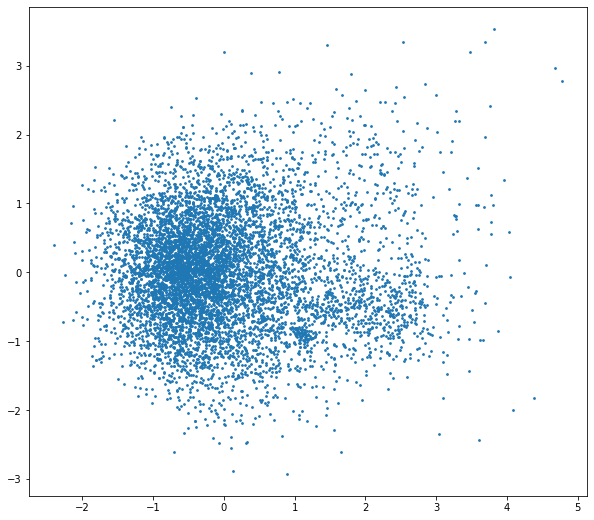

In [10]:
cluster_embedding = vetorDoc_pca
plt.figure(figsize=(10,9))
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=3, cmap='Spectral')

## Verificando o nr ideal de clusters

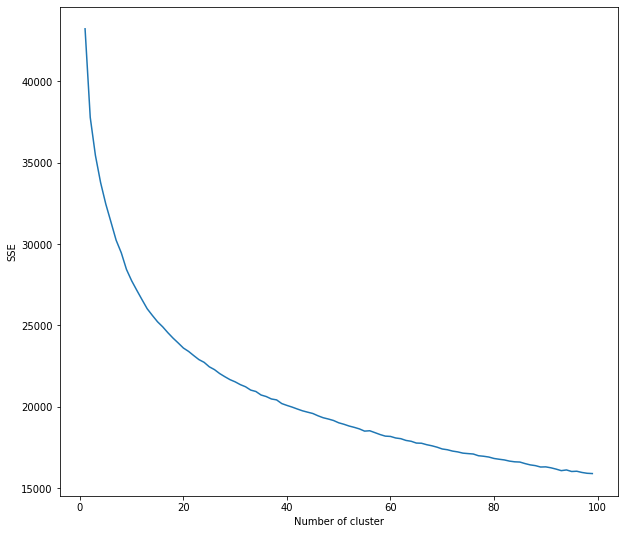

In [17]:


sse = {}
for k in range(1, 100):
    kmeans = KMeans(n_clusters=k, max_iter=500).fit(cluster_embedding)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center

plt.figure(figsize=(10,9))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

## Cluster K-means

In [13]:
kmeans = KMeans(n_clusters=90).fit(cluster_embedding)
cluster = kmeans.predict(cluster_embedding)

## Cluster hierárquico

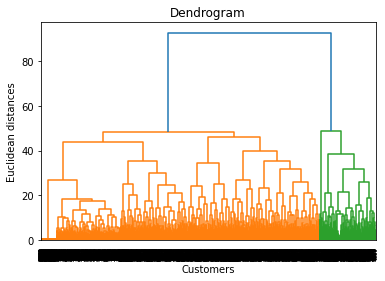

In [20]:
import scipy.cluster.hierarchy as sch
dendrogram = sch.dendrogram(sch.linkage(cluster_embedding, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.show()

In [14]:
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters = 90, affinity = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(cluster_embedding)

In [15]:
df_cluster = pd.DataFrame(list(zip(cluster, w2v_total_data, y_hc)), 
               columns =['cluster', 'vocabulo', 'cluster_hie'])
df_cluster.head()

,cluster,vocabulo,cluster_hie
0,33,senha do cartao credito,35
1,33,compra ja reembolsada,35
2,33,faco tudo certinho no final dados invalidos,35
3,33,ja tentei entrar,12
4,50,pq pede senha do cartao mudar numero nao lembr...,44


## Função de n-grams por cluster - método k-means

In [16]:
def ranking_cluster(df_clean, cluster):
    
    df_agg_ungroup_final = pd.DataFrame([], columns=['unigram', 'unigram_freq',
                                                     'bigram','bigram_freq','trigram','trigram_freq', 'cluster'])
    
    for i in df_clean[cluster].unique():
        try:
            df_clean_tmp = df_clean[df_clean[cluster] == i ]
            df_clean_tmp['dt_envio_mensagem'] = pd.to_datetime("2022-01-01")
            df_agg_ungroup_tmp = arabica_freq(
                text = df_clean_tmp['vocabulo'],
                time = df_clean_tmp['dt_envio_mensagem'],
                time_freq = 'ungroup',           # opção ungroup
                max_words = 10,             
                stopwords = ['portuguese'],   
                skip = [stopwords],         
                numbers = True,            
                punct = True,              
                lower_case = True) 
            
            result_temp = pd.DataFrame({'unigram': df_agg_ungroup_tmp['unigram'], 'unigram_freq': df_agg_ungroup_tmp['unigram_freq'],
                                        'bigram': df_agg_ungroup_tmp['bigram'], 'bigram_freq': df_agg_ungroup_tmp['bigram_freq'],
                                        'trigram': df_agg_ungroup_tmp['trigram'], 'trigram_freq': df_agg_ungroup_tmp['trigram_freq']}, index=[0])
            
            result_temp['cluster'] = i
                    
            df_agg_ungroup_final = df_agg_ungroup_final.append(result_temp)

        except IndexError:
            pass
                
    
    df_agg_ungroup_final['unigram_freq'] = df_agg_ungroup_final['unigram_freq'].astype('int')
    df_agg_ungroup_final['bigram_freq'] = df_agg_ungroup_final['bigram_freq'].astype('int')
    df_agg_ungroup_final['trigram_freq'] = df_agg_ungroup_final['trigram_freq'].astype('int')
    df_agg_ungroup_final['cluster'] = df_agg_ungroup_final['cluster'].astype('str')

    df_agg_ungroup_final['unigram_h'] = df_agg_ungroup_final['cluster'] + ' : ' + df_agg_ungroup_final['unigram']
    df_agg_ungroup_final['bigram_h'] = df_agg_ungroup_final['cluster'] + ' : ' + df_agg_ungroup_final['bigram']
    df_agg_ungroup_final['trigram_h'] = df_agg_ungroup_final['cluster'] + ' : ' + df_agg_ungroup_final['trigram']
    
    return df_agg_ungroup_final

In [29]:
df_resumo = ranking_cluster(df_cluster, 'cluster')

/tmp/ipykernel_1335126/3487320479.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_1335126/3487320479.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_1335126/3487320479.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_1

In [30]:
df_resumo.head()

,unigram,unigram_freq,bigram,bigram_freq,trigram,trigram_freq,cluster,unigram_h,bigram_h,trigram_h
0,nao,75,"nao,consigo",4,"pedir,segunda,via",2,8,8 : nao,"8 : nao,consigo","8 : pedir,segunda,via"
0,nao,43,"queria,saber",4,"queria,cancelar,cartao",2,4,4 : nao,"4 : queria,saber","4 : queria,cancelar,cartao"
0,nao,41,"gostaria,saber",5,"nao,conseguindo,fazer",2,44,44 : nao,"44 : gostaria,saber","44 : nao,conseguindo,fazer"
0,nao,44,"queria,saber",4,"nova,via,cartao",3,72,72 : nao,"72 : queria,saber","72 : nova,via,cartao"
0,nao,30,"queria,saber",5,"fatura,vence,dia",2,61,61 : nao,"61 : queria,saber","61 : fatura,vence,dia"


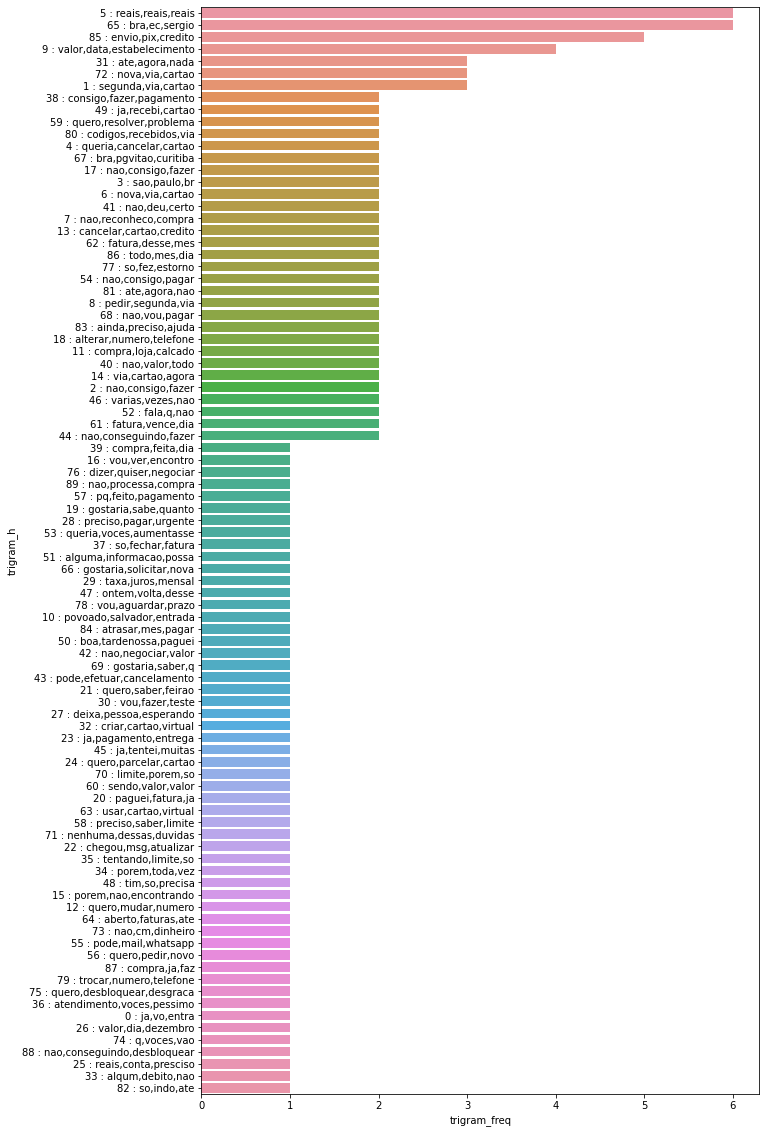

In [31]:
plt.figure(figsize=(10,20))
sns.barplot(data = df_resumo.sort_values(by ='trigram_freq', ascending=False), x = 'trigram_freq', y = 'trigram_h')
plt.show()

In [32]:
df_resumo2 = ranking_cluster(df_cluster, 'cluster_hie')

/tmp/ipykernel_1335126/3487320479.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_1335126/3487320479.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_1335126/3487320479.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_1

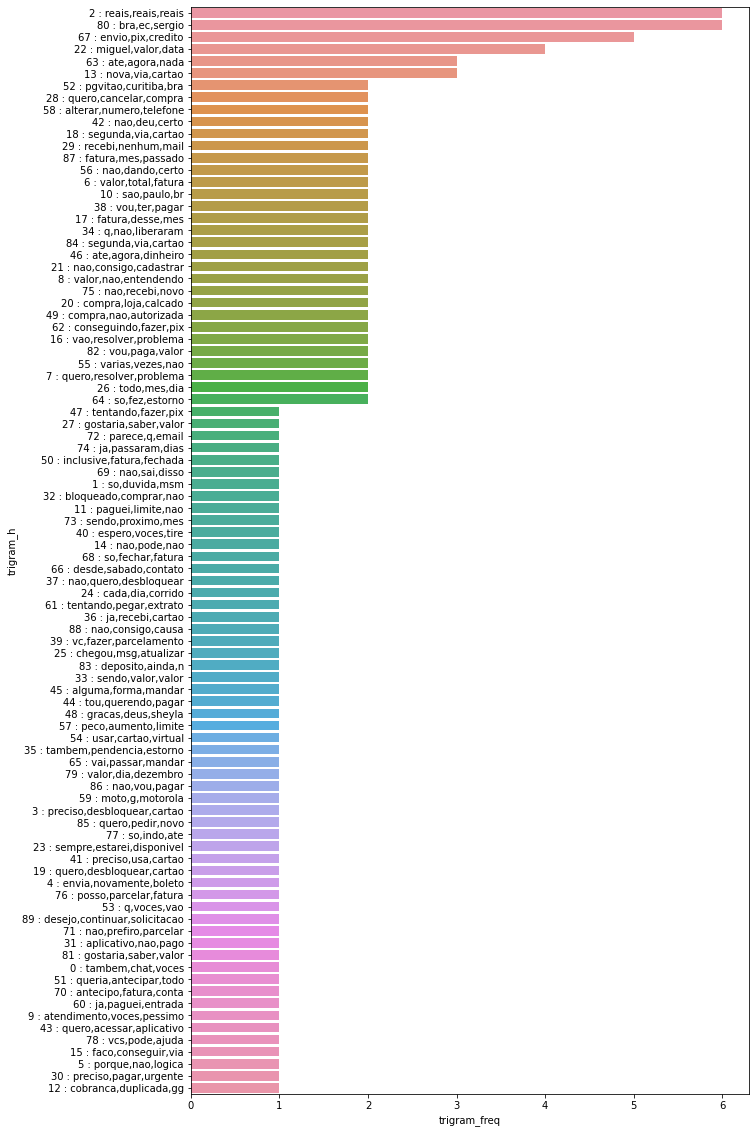

In [33]:
plt.figure(figsize=(10,20))
sns.barplot(data = df_resumo2.sort_values(by ='trigram_freq', ascending=False), x = 'trigram_freq', y = 'trigram_h')
plt.show()

## Cluster x fila de atendimento - k-means

- Relacionar clusters com filas de atendimento.

Objetivo: avaliar se os mesmos tipos de vocábulos são usados para quais assuntos

In [ ]:
df_clean2 = df_clean.join(df_cluster, how = 'left', lsuffix='ds_mensagem_tratada', rsuffix='vocabulo')


In [84]:
df_agg = df_clean2.groupby(['cluster', 'fila_de_atendimento'], as_index = False).agg({'ds_message_tratada':['count']})
df_agg.columns = df_agg.columns.droplevel(0)
df_agg.columns = ['cluster', 'fila_de_atendimento', 'count']

fig = px.bar(df_agg, x='cluster', y = 'count', color = 'fila_de_atendimento', barmode='group')
fig.update_layout(height = 800
    , width = 2000, xaxis_nticks=36)
fig.show()

In [89]:
df_clean2[['cluster', 'ds_message_tratada']].query('cluster == 87')

,cluster,ds_message_tratada
134,87.0,quero negociar chat
755,87.0,screenshotsent
776,87.0,screenshotsent
868,87.0,quero parcelar fatura
952,87.0,nenhuma dessas
1030,87.0,vou cancelar
1074,87.0,clico onde ora troca senha
1075,87.0,dia preciso disso hoje mary
1110,87.0,nao consigo pagar tudo
1115,87.0,valor juros paga na proxima fatura ou desconta...


## Cluster x fila de atendimento - Hierarquico

In [90]:
df_agg = df_clean2.groupby(['cluster_hie', 'fila_de_atendimento'], as_index = False).agg({'ds_message_tratada':['count']})
df_agg.columns = df_agg.columns.droplevel(0)
df_agg.columns = ['cluster_hie', 'fila_de_atendimento', 'count']

fig = px.bar(df_agg, x='cluster_hie', y = 'count', color = 'fila_de_atendimento', barmode='group')
fig.update_layout(height = 800
    , width = 2000, xaxis_nticks=36)
fig.show()

In [96]:
df_clean2[['cluster_hie', 'ds_message_tratada']].query('cluster_hie == 36')

,cluster_hie,ds_message_tratada
1353,36.0,saber qual limite aprovado no wil
1599,36.0,elisandra
1872,36.0,quero negociar chat
2111,36.0,teria fazer nova senha
2211,36.0,se dinheiro precisando fazer transferencia vc...
2449,36.0,screenshotsent
2571,36.0,cancela conta
2595,36.0,eles me passaram seria entrar contato voces
2749,36.0,pelas informacoes
2753,36.0,quero negociar fatura


## Análise de sentimento


Objetivo: Avaliar distribuição / relacionar com assuntos / tipos de vocábulos que indicam sentimento mais negativo (para o tipo pegar a melhor clusterização)

In [5]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.downloader.download('vader_lexicon')

# Initialize the sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/flavia.costa/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [6]:
# Create a new column in the dataframe to store the sentiment scores
df_clean["sentiment"] = 0.0

# Iterate over the rows of the dataframe
for index, row in df.iterrows():
  # Use the analyzer to predict the sentiment of the text
  scores = analyzer.polarity_scores(row["ds_message_tratada"])
  # Store the compound score in the new column
  df_clean.at[index, "sentiment"] = scores["compound"]

In [7]:
fig = px.histogram(df_clean, x="sentiment")
fig.show()

In [9]:
fig = px.histogram(df_clean.query('sentiment != 0'), x="sentiment")
fig.show()

In [8]:
df_clean[['ds_message_tratada', 'sentiment']].query('sentiment < -0.5').sort_values(by = 'sentiment', ascending=True).drop_duplicates()

,ds_message_tratada,sentiment
20178,enviei lhes esta mensagem tirar duas duvidas v...,-0.8807
49595,breve relato compra no estacionamento porcelan...,-0.8402
48910,aparece no cartao valor feito no dia riscado n...,-0.7783
37233,porque mesmo juro tu muito alto credicard zero...,-0.7783
3254,valor compra no dia no dia abril novo no dia ...,-0.7783
...,...,...
8235,quando estava falando vcs insta pessoa mandou ...,-0.5267
19580,recebi r$ no pix hoje tarde saldo conta ainda ...,-0.5267
25445,no caso no dia agora nao posso pagar fatura ju...,-0.5267
49960,tentando fazer nova senha npara transacoes no ...,-0.5267


In [10]:
df_clean[['ds_message_tratada', 'sentiment']].query('sentiment > 0.6').sort_values(by = 'sentiment', ascending=True).drop_duplicates()

,ds_message_tratada,sentiment
1245,amor atendimento ja descobri origem compra me ...,0.6124
29674,amor deus alguem me atende,0.6124
30389,amor deus,0.6124
31652,amor deus me ajuda,0.6124
33965,amor deus faco pix extorno,0.6124
35357,amor sei pedindo,0.6124
37836,gente amor deus cansada explicar motivo precis...,0.6124
39733,amor deus cancela transferencia agendada dia s...,0.6124
40617,moca amor deus,0.6124
41026,nao amor coracao deus te abencoe te proteja se...,0.6124


## Cluster com vetorização do algoritmo hero + k-means

Objetivo: Testar uma outra forma de separação e repetir a análise de vocábulos x assuntos

In [12]:
df_clean3 = df_clean.sample(5000)

In [14]:
df_clean3['pca'] = (
   df_clean3['ds_message_tratada']
   .pipe(hero.clean)
   .pipe(hero.tfidf)
   .pipe(hero.pca)
)

df_clean3['pca_1'] = df_clean3['pca'].astype('string').str.split(",").str[1]
df_clean3['pca_2'] = df_clean3['pca'].astype('string').str.split(",").str[0]

for i in ['pca_1','pca_2']:
    df_clean3[i] = df_clean3[i].str.replace(']','').str.replace('[','').astype("float")

In [15]:
kmeans = KMeans(n_clusters=90).fit(df_clean3[['pca_1','pca_2']])
cluster = kmeans.predict(df_clean3[['pca_1','pca_2']])

df_clean3['cluster_hero'] = cluster

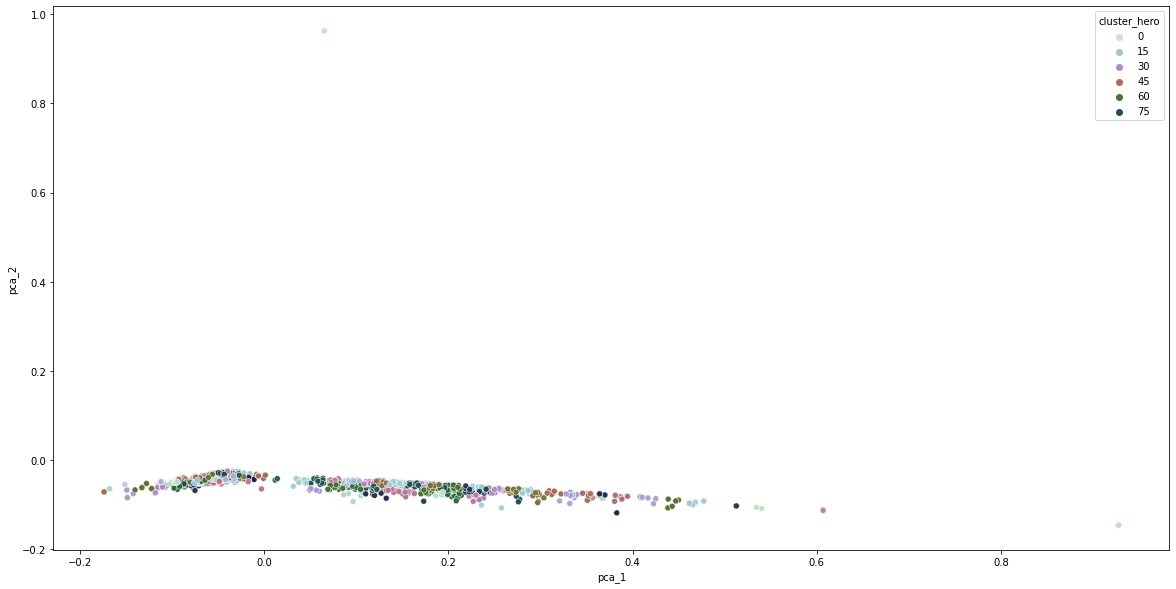

In [23]:
plt.figure(figsize=(20,10))
sns.scatterplot(data = df_clean3, x = 'pca_1', y = 'pca_2', hue='cluster_hero', palette="ch:s=1,rot=-2")
plt.show()

In [28]:


for i in df_clean3.cluster_hero.unique():
    print("================= CLUSTER " + str(i) + "===========")
    print(df_clean3[['cluster_hero','ds_message_tratada']][df_clean3['cluster_hero'] == i].value_counts(normalize=True))

================= CLUSTER 0===========
cluster_hero  ds_message_tratada                   
0             quitacao                                 0.037931
              nenhum anteriores                        0.034483
              me mostra no will                        0.017241
              x                                        0.013793
              vez                                      0.013793
                                                         ...   
              iae sigo no aguardo                      0.003448
              irei bloquear                            0.003448
              irei enviar                              0.003448
              irei enviar print ordem toda conversa    0.003448
              ohh print aparece                        0.003448
Length: 247, dtype: float64
================= CLUSTER 80===========
cluster_hero  ds_message_tratada                                                                                                         